**Final Project**

Anna Kopec

LING 3000Q

Stefan Kaufmann

In [ ]:
import os
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling

In [ ]:
# make sure code runs on gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

In [ ]:
# import Moby Dick text from Project Gutenberg
import requests
r = requests.get('https://gutenberg.org/cache/epub/2554/pg2554.txt')
r.encoding = 'utf-8-sig'
max_len = 512

In [ ]:
def clean_text(text):
    '''method takes novel text, gets rid of all text before and after default headers,
    then further remove special characters between words except for punctuation at ends of sentences and
    single apostrophes
    return list of reformatted sentences, and the length of the longest sentence (to use as len of sentence arrays)'''
    text = re.sub(r'^.*\*\*\* START OF THE PROJECT GUTENBERG .*?\*\*\*', '', text, flags=re.DOTALL|re.IGNORECASE)
    text = re.sub(r'\*\*\* END OF THE PROJECT GUTENBERG .*?$', '', text, flags=re.DOTALL|re.IGNORECASE)
    text = re.sub(r'^\s*(CHAPTER|[XIV]+|PAGE|PART)\s+.*$', '', text, flags=re.MULTILINE)
    text = re.sub(r'^\s*[0-9]+\s*$', '', text, flags=re.MULTILINE)
    text = re.split(r'[.?!|]', text)

    clean_sents = []
    len_sents = []
    def clean_line(line):
        line = re.sub(r'[_*#=~;“”‘’,+\[\]\\()\|<>]', '', line)

        line = re.sub(r'\r\n|\r', ' ', line)
        line = re.sub(r'—', ' ', line)
        line = re.sub(r'(?<!\n)\n(?!\n)', ' ', line)
        line = re.sub(r'[  ]+'," ",line)
        line += "."
        return line

    for line in text:
        cleaned_line = clean_line(line)
        n = len(line.split(" "))
        # select only longer sentences, as they are better for training
        if 15 < n < max_len:
            clean_sents.append(cleaned_line)
            len_sents.append(n)
    return clean_sents, len_sents


In [ ]:
# clean text and encode it using the tokenizer
text, text_len = clean_text(r.text)
max_len = max(text_len) #set size of tensor to = size of largest sentence
inputs = tokenizer(text, max_length=max_len, truncation=True, padding='max_length', return_tensors='pt')

In [ ]:
class MLMDataset(Dataset):
    '''custom dataset class that will hold all sentence data from tokenizer'''
    def __init__(self, texts, tokenizer, max_length=128):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

In [ ]:
def mask_inputs(input_ids, tokenizer):
    '''this method implements masking, where 15% of all tokens are either '''
    input_ids = input_ids.clone()
    labels = input_ids.clone()

    batch_size, seq_len = input_ids.shape

    for i in range(batch_size):
        rand = torch.rand(seq_len)
        # for each token, 15% probability to be chosen
        # exclude special sentence start, sentence end, and padding tokens
        mask_arr = ((rand < 0.15) &
                    (input_ids[i] != tokenizer.pad_token_id) &
                    (input_ids[i] != tokenizer.cls_token_id) &
                    (input_ids[i] != tokenizer.sep_token_id))

        selection = torch.flatten(mask_arr.nonzero()).tolist()
        # 80% chance to mask, 10% to switch to random word, 10% to keep as is
        for idx in selection:
            prob = torch.rand(1).item()
            if prob < 0.8:
                input_ids[i, idx] = tokenizer.mask_token_id
            elif prob < 0.9:
                input_ids[i, idx] = torch.randint(999, tokenizer.vocab_size, (1,)).item()
        # represent non-masked tokens as -100 in the labels array
        labels[i][~mask_arr] = -100
    # return input_ids (sentences with randomly modified tokens), and labels (words represented by MASK)
    return input_ids.to(device), labels.to(device)

In [ ]:
def collate_fn(batch):
    '''this function modifies data from our dataset with the custom mask_inputs method, called during dataloader initialization'''
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    masked_input_ids, labels = mask_inputs(input_ids, tokenizer)
    return {
        'input_ids': masked_input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# initialize dataset
dataset = MLMDataset(text, tokenizer, max_length=max_len)
# dataloader for passing in data as batches during training
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [ ]:
model.to(device)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 5
loss_values = []

# training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # call model on masked inputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        # store summed loss
        total_loss += loss.item()

        # backpropagation to reduce loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)

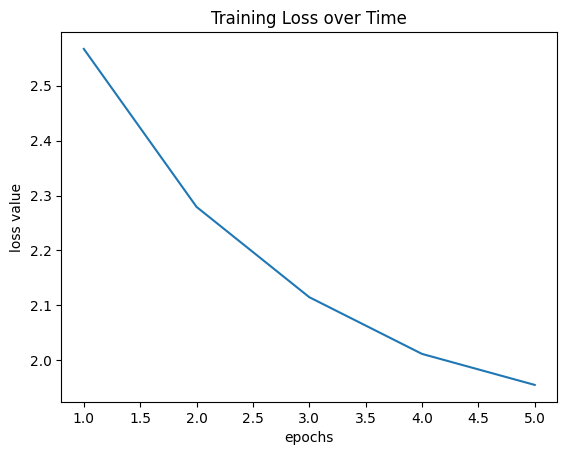

In [ ]:
# plot loss over time
x = [i+1 for i in range(num_epochs)]
y = loss_values
plt.plot(x, y)
plt.title("Training Loss over Time")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()